# Assignment 6 - Graph drawing and network analysis

In this assignment you will get to work with graphs using the [graph-tool python module](https://graph-tool.skewed.de/).

Learning goals are:

* perform basic network analysis to create derived graph properties,
* visualize graphs and their properties.

If you require an introduction to basic graph notions, consider to read the so-titled section in [Maël Fabien
's introductory blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5). While graph theory and algorithms can lead to fairly deep mathematical discussion, basic definitions and much practical use of graph data are quite easy to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and the [tutorial notebook](https://stevenbergner.github.io/Teaching/cmpt767/graph-tool-tutorial-todo.ipynb). See the [lab setup](#Environment-setup) section below to learn about the `gt conda` environment that has all required dependencies installed in the Big Data Lab.

In [6]:
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

graph-tool version: 2.29


# Problem 1: Power grid analysis

In [2]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

In [3]:
g.vp.vfilter = g.new_vp('int')

for v in g.vertices():
    if v.out_degree() > 10:
        g.vp.vfilter[v] = 15;

 In this graph an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

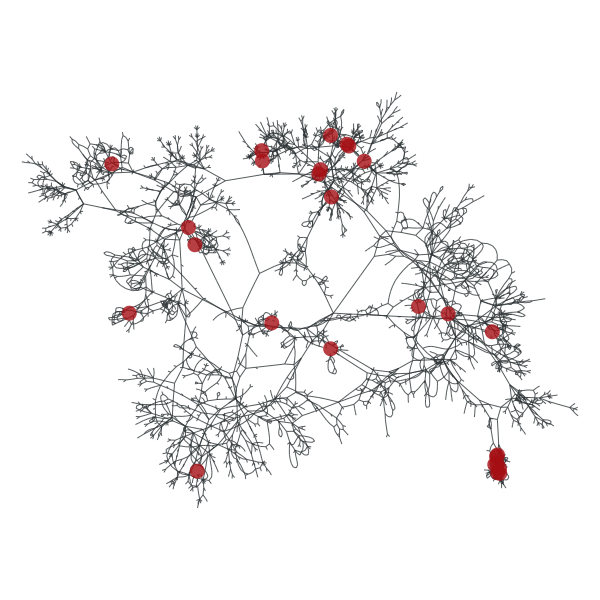

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f819abbc250, at 0x7f81c15a4990>

In [4]:
gt.graph_draw(g, vertex_size = g.vp.vfilter, edge_pen_width=1)

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

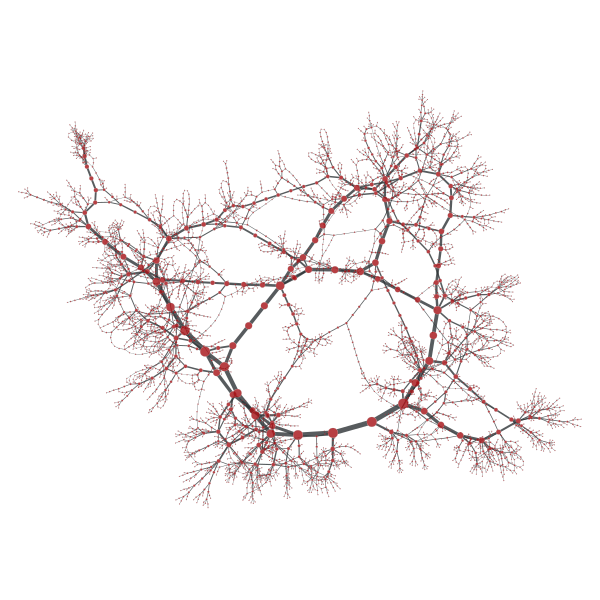

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f819abbc250, at 0x7f81d871ab50>

In [9]:
# TODO
vb, eb = gt.betweenness(g)
gt.graph_draw(g,
              edge_pen_width=gt.prop_to_size(eb, mi=0.1, ma=5),
              vertex_size=gt.prop_to_size(vb, mi=1, ma=10))

# Problem 2: Small social graph visualization

In [22]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph based on the information above, remove parallel edges, and draw it using a layout that resembles the tidy example given below.

In [23]:
X_edges = list((n,k) for n in X_knows for k in X_knows[n])
from functools import reduce
X_names = reduce(lambda a,b: set(a).union(b),
                 (X_knows[n] for n in X_knows)
                ).union(X_knows.keys())
X_names = list(X_names)

In [24]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lem = le.fit(list(X_names))
X_edges = list(map(lem.transform, X_edges))

In [25]:
g = gt.Graph(directed=False)
v_name = g.new_vertex_property('string')
g.vertex_properties['name'] = v_name

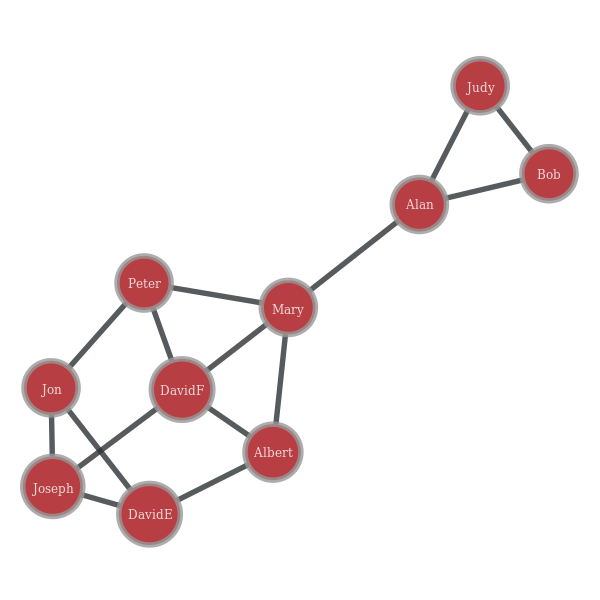

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff45780f1d0, at 0x7ff45780fe90>

In [26]:
for vn in lem.classes_:
    v = g.add_vertex()
    v_name[v] = vn
    
for f,t in X_edges:
    g.add_edge(f,t)

gt.remove_parallel_edges(g)
gt.graph_draw(g, vertex_text=v_name)

# Problem 3: Facebook graph analysis

For the following question let us work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. the friends of each of these users and the connections among those friends.

Goal of the following questions is to use centrality measures to determine influencers among the users, not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [27]:
with open('facebook_combined.txt', 'r') as txt_file:
    fb_list = [line.rstrip('\n').split() for line in txt_file]
fb_list = [(int(x[0]), int(x[1])) for x in fb_list]
g = gt.Graph(directed=False)
g.add_edge_list(fb_list)

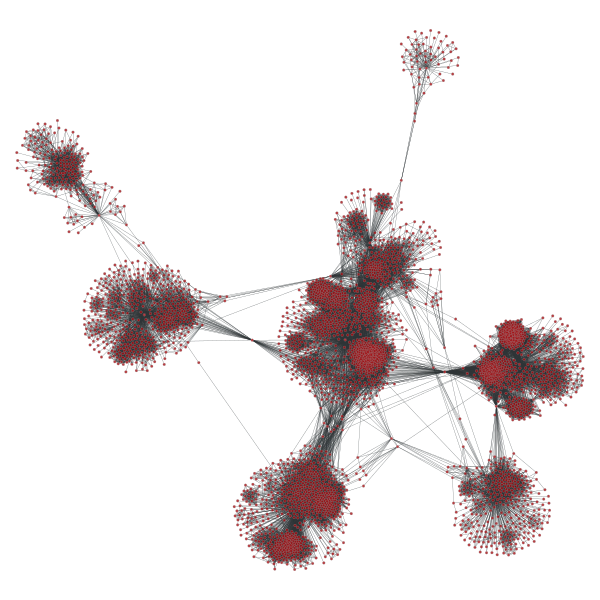

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff443a19990, at 0x7ff4577f7850>

In [29]:
gt.graph_draw(g)

**Task 3b:** Calculate and show a histogram of pairwise distances among users, i.e. on the shortest paths of friendship connections among any pair of users. Use a log-scale to show the frequencies in the histogram. What is the diameter of this graph?

*Hint:* Calculating and drawing the histogram amounts to two lines of code using `gt` and `plt` modules.

(array([1.970e+02, 6.800e+01, 1.278e+03, 1.380e+03, 8.890e+02, 1.990e+02,
        2.300e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 PropertyArray([0.17825454, 0.20639903, 0.23454352, 0.26268801, 0.2908325 ,
                0.31897699, 0.34712149, 0.37526598, 0.40341047, 0.43155496,
                0.45969945]),
 <a list of 10 Patch objects>)

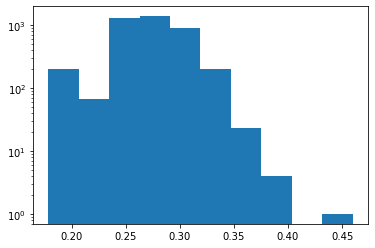

In [30]:
c = gt.closeness(g)
plt.hist(c.get_array(), log=True)

**Task 3c:** Determine influencers, i.e. people withing the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) and drawing that only retains nodes with a `pagerank` $< 0.002$.

In [31]:
pr = gt.pagerank(g)
gv = gt.GraphView(g, vfilt=lambda v: pr[v] < 0.002)

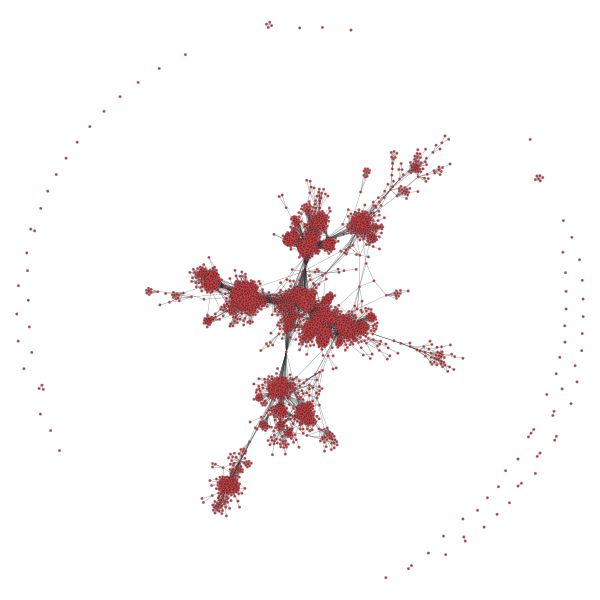

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff4576c3a10, at 0x7ff457655950>

In [34]:
gt.graph_draw(gv)

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

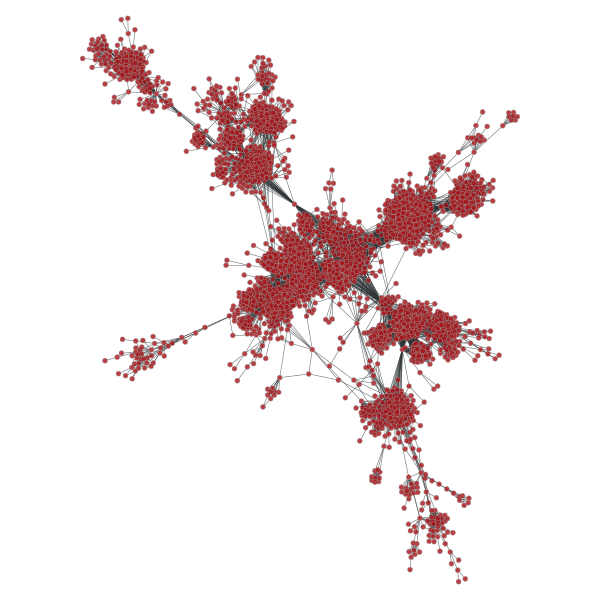

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff457655250, at 0x7ff4576b13d0>

In [37]:
gv = gt.GraphView(gv, vfilt=gt.label_largest_component(gv))
gt.graph_draw(gv, vertex_size=gt.prop_to_size(gt.label_largest_component(gv), mi=5, ma=15))

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that potentially play central roles among their friends.

In [38]:
pr = gt.pagerank(g)
gv = gt.GraphView(g, vfilt=lambda v: pr[v] < 0.0005)

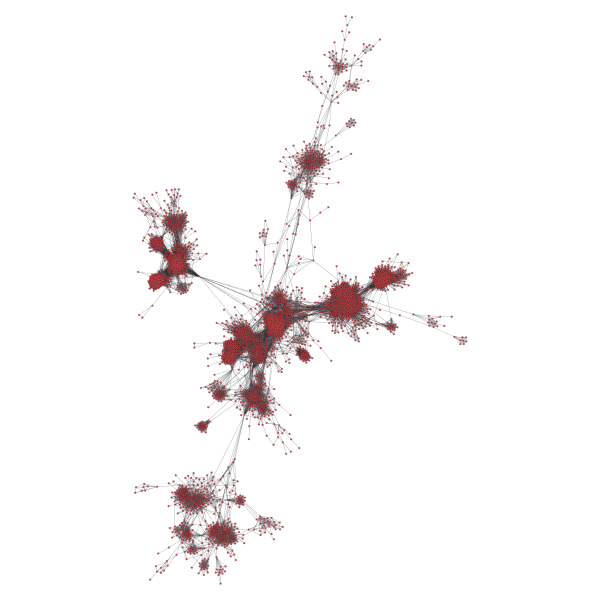

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff45769b790, at 0x7ff4576a4610>

In [42]:
gv = gt.GraphView(gv, vfilt=gt.label_largest_component(gv))
gt.graph_draw(gv, vertex_size=gt.prop_to_size(gt.label_largest_component(gv), mi=2, ma=15))

# Environment setup

## Lab setup
We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/gt
```
You should now be able to `import graph_tool` in a python 3 session or inside jupyter notebooks.

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
conda init bash
conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

#### Reproduce the conda setup in the lab

In case you want to reproduce the setup, here are the calls used to create the environment:
```
conda create -n gt
conda activate gt
conda install -c conda-forge graph-tool
conda install -c pkgw-forge -c conda-forge gtk3 pygobject
conda install -c conda-forge jupyter jupyterlab
conda install -c conda-forge matplotlib scikit-learn seaborn networkx igraph pyintergraph graphviz
```


## Setup on Linux (Ubuntu or WSL)

If you have sudo privileges, you can simply run
```
sudo apt install python3-graph-tool
```
and proceed to install further Python dependencies via `pip`, not requiring anaconda.
In case there are issues with drawing functionality, you may also need
```
sudo install libcairo2-dev xdg-utils graphviz
```

Note, that this also works on Windows' WSL (Windows Sub-shell for Linux) running Ubuntu, in case you do not want to launch a VM for this.

## Other environments and remote use

Setting up `graph_tool` on Mac OSX is possible via `brew`, but evidence online suggests that this may not be straightforward.
Since the [conda-forge graph-tool package](https://anaconda.org/conda-forge/graph-tool) is available for `osx-64`, maybe you want to try installing via `conda` instead of `brew`.

Remote use of the lab setup is possible, but tricky. Familiarize yourself with a shell session manager, such as [`tmux`](https://tmuxcheatsheet.com/) or GNU [`screen`](https://gist.github.com/fredrick/1216878) to keep an ssh session open once you logged into a lab machine. To connect to a jupyter notebook remotely you could create a [`ngrok`](https://ngrok.com/) account and use their http port tunneling. If you have questions about this method, ask Steven in the lab for more hints.


# Submission instructions
Please submit [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) with filled out code cells and figures included to [CourSys activity A6](https://coursys.sfu.ca/2020sp-cmpt-733-g1/+a6/).